In [1]:
# mount data
from google.colab import drive
drive.mount('/content/drive')
data_folder = '/content/drive/MyDrive/Thesis/data'

Mounted at /content/drive


In [2]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import numpy as np
import datetime

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

from sklearn.metrics import mean_squared_error

from sklearn.metrics import mean_absolute_percentage_error as mape
import matplotlib.pyplot as plt

# settings
plt.style.use("seaborn-paper")
plt.rcParams["figure.figsize"] = (8, 6)

<ipython-input-2-e750869b5fad>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-paper")


# Germany

## Load T2 data

In [3]:
def load_T2_data(country_name):
  # Load the T2_balances data from an Excel file
  T2_balances = pd.read_excel(data_folder+'/TGB_month_avg.xls', header=1)

  # Find the specific country in the 'REF_AREA.265 [desc.]' column
  country = [x for x in T2_balances['REF_AREA.265 [desc.]'].unique() if country_name in x][0]

  # Define the columns to be used
  col_to_use = ['Obs. date', 'Obs. value']

  # Filter the T2_balances DataFrame for the specified country
  country_T2 = T2_balances[T2_balances['REF_AREA.265 [desc.]'] == country]

  # Select only the desired columns and reset the index
  country_T2 = country_T2[col_to_use].reset_index(drop=True)

  # Rename the columns to 'T2_balance' and 'date'
  country_T2.rename(columns={'Obs. value': 'T2_balance', 'Obs. date': 'date'}, inplace=True)

  # Sort the DataFrame by date in ascending order and reset the index
  country_T2 = country_T2.sort_values('date', ascending=True).reset_index(drop=True)

  # Return the processed country_T2 DataFrame
  return country_T2

In [4]:
# Load Germany data
Germany_T2 = load_T2_data('Germany')

In [5]:
# Calculate monthly changes
Germany_T2['1st_diff'] = Germany_T2['T2_balance'].diff(1)

## Statistical tests on T2_balance change

### Plot distribution

In [6]:
# Calculate the count of rows in Germany_T2 DataFrame satisfying specific conditions and group them by year
Germany_T2.loc[(Germany_T2['1st_diff']>0) & (Germany_T2['1st_diff']<10000)].groupby(Germany_T2.date.dt.year).size()

date
2001    4
2002    8
2003    3
2004    7
2005    6
2006    4
2007    5
2008    5
2009    5
2010    6
2011    5
2012    3
2013    1
2014    4
2015    2
2016    5
2017    3
2018    3
2019    1
2020    1
2021    2
2022    3
dtype: int64

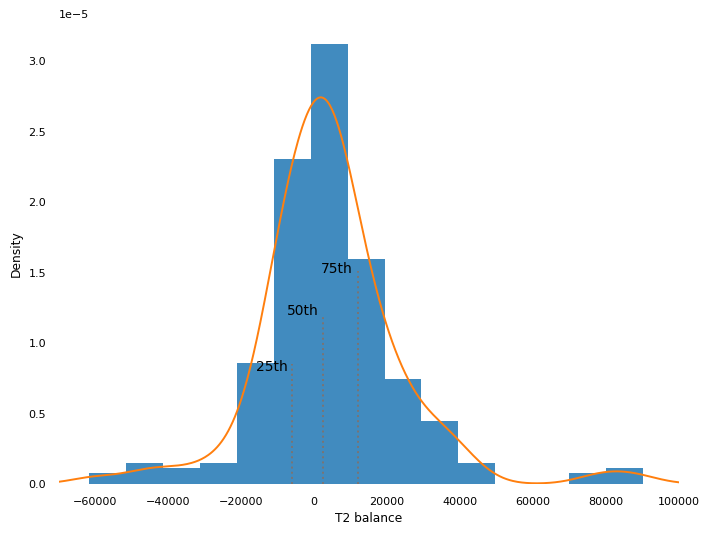

In [7]:
# Create a figure and axis object with a specific size
fig, ax = plt.subplots(figsize=(8, 6))

# Plotting
    # Plot a histogram of the '1st_diff' column
Germany_T2['1st_diff'].plot(kind="hist", alpha=0.85, density=True, bins=15)  # Change density to True because KDE uses density
    # Plot a kernel density estimate (KDE) of the '1st_diff' column
Germany_T2['1st_diff'].plot(kind="kde")

    # Quantile lines
# Calculate the quantiles (25th, 50th, and 75th percentiles) of the '1st_diff' column
quant_25, quant_50, quant_75 = Germany_T2['1st_diff'].quantile(0.25), Germany_T2['1st_diff'].quantile(0.5), Germany_T2['1st_diff'].quantile(0.75)
quants = [[quant_25, 0.8, 0.26], [quant_50, 1, 0.36], [quant_75, 0.8, 0.46]]
# Draw vertical lines at the specified quantiles on the plot
for i in quants:
    ax.axvline(i[0], color='#797474', ymax=i[2], linestyle=":")

# X-axis
# Set the label for the x-axis
ax.set_xlabel("T2 balance")
x_start, x_end = -70000, 100000
# Set the limits for the x-axis
ax.set_xlim(x_start, x_end)

# Annotations
# Add text annotations for the quantile lines
ax.text(quant_25 - 10000, 0.8e-5, "25th")
ax.text(quant_50 - 10000, 1.2e-5, "50th")
ax.text(quant_75 - 10000, 1.5e-5, "75th")

# Overall settings
# Disable grid lines
ax.grid(False)

# Remove ticks and spines
ax.tick_params(left=False, bottom=False)
for ax, spine in ax.spines.items():
    spine.set_visible(False)

# Display the plot
plt.show()

### ADF test

In [8]:
# Import the adfuller function from the statsmodels.tsa.stattools module
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test on the '1st_diff' column of Germany_T2 after dropping any NaN values
result = adfuller(Germany_T2['1st_diff'].dropna().values)

# Print the ADF statistic from the test result
print('ADF Statistic: %f' % result[0])

# Print the p-value from the test result
print('p-value: %f' % result[1])

# Print the critical values from the test result
print('Critical Values:')
# Iterate over the dictionary of critical values and print each key-value pair
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.098072
p-value: 0.000976
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573


### Seasonal decomposition

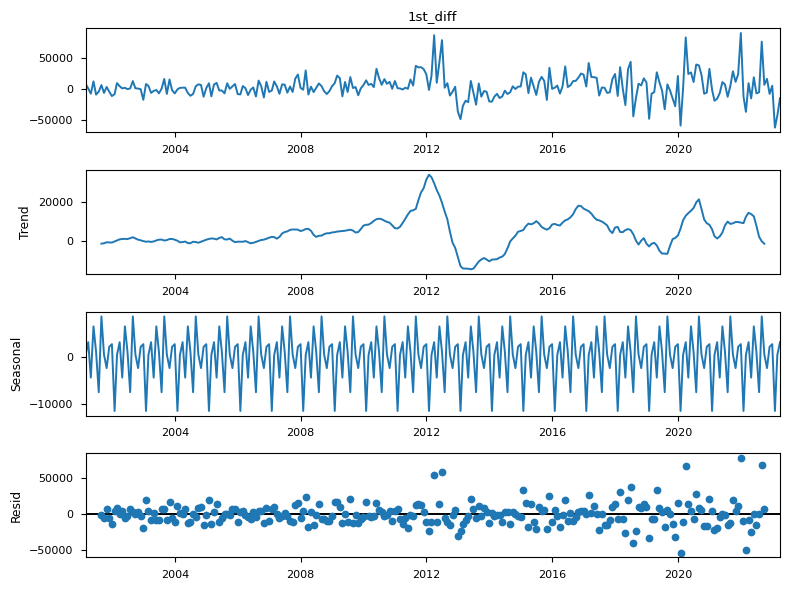

In [9]:
# Import the seasonal_decompose function from the statsmodels.tsa.seasonal module
from statsmodels.tsa.seasonal import seasonal_decompose

# Close any existing plots
plt.close()

# Perform seasonal decomposition on the '1st_diff' column of Germany_T2
# Set the index of Germany_T2 as 'date' and resample it to a monthly frequency (M)
# Drop any NaN values in the resampled series
# Use an additive model
analysis = seasonal_decompose(Germany_T2.set_index('date').asfreq('M')['1st_diff'].dropna(), model="additive")

# Plot the decomposition results
analysis.plot()

# Display the plot
plt.show()

In [10]:
analysis.seasonal.value_counts()

469.499       23
3196.724      23
-4345.162     22
6550.556      22
1135.341      22
-7446.104     22
8673.126      22
560.256       22
-2326.205     22
2203.554      22
2769.973      22
-11441.557    22
Name: seasonal, dtype: int64

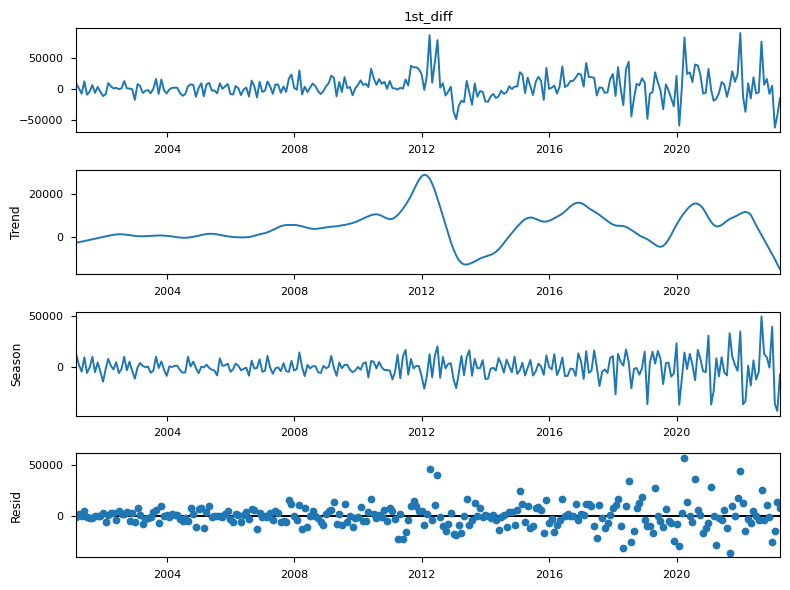

In [ ]:
# Import the STL function from the statsmodels.tsa.seasonal module
from statsmodels.tsa.seasonal import STL

# Perform STL decomposition on the '1st_diff' column of Germany_T2
# Set the index of Germany_T2 as 'date' and resample it to a monthly frequency (M)
# Drop any NaN values in the resampled series
stl_result = STL(Germany_T2.set_index('date').asfreq('M')['1st_diff'].dropna()).fit()

# Plot the STL decomposition results
stl_result.plot()

# Display the plot
plt.show()

### Autocorrelation and partial autocorrelation

In [ ]:
# Import the acf function from the statsmodels.tsa.stattools module
from statsmodels.tsa.stattools import acf

# Calculate the autocorrelation function (ACF) of the '1st_diff' column of Germany_T2
# Drop any NaN values in the series
# Set the maximum number of lags to consider as 50
acf_b = acf(Germany_T2['1st_diff'].dropna().values, nlags=50)

# Find the indices where the absolute value of the ACF is greater than 0.2
lag_indices = np.where(abs(acf_b) > 0.2)


(array([ 0,  1,  3, 23]),)

In [ ]:
# Import the pacf function from the statsmodels.tsa.stattools module
from statsmodels.tsa.stattools import pacf

# Calculate the partial autocorrelation function (PACF) of the '1st_diff' column of Germany_T2
# Drop any NaN values in the series
# Set the maximum number of lags to consider as 50
pacf_b = pacf(Germany_T2['1st_diff'].dropna().values, nlags=50)

# Find the indices where the absolute value of the PACF is greater than 0.2
lag_indices = np.where(abs(pacf_b) > 0.2)


(array([ 0,  1,  3, 13, 23]),)

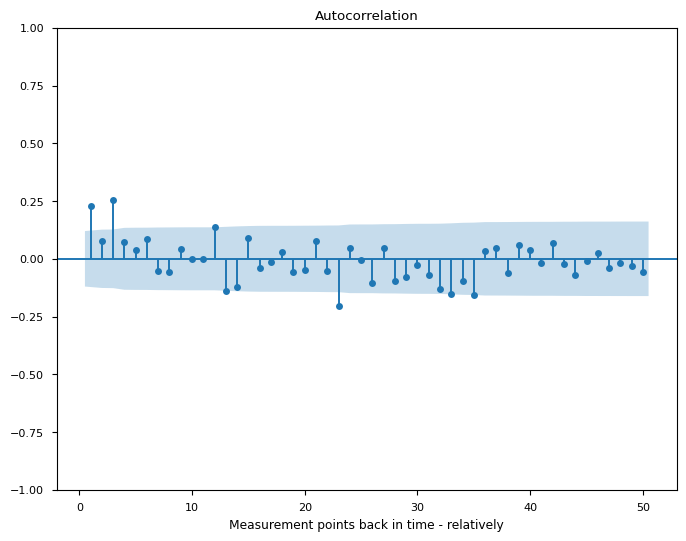

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


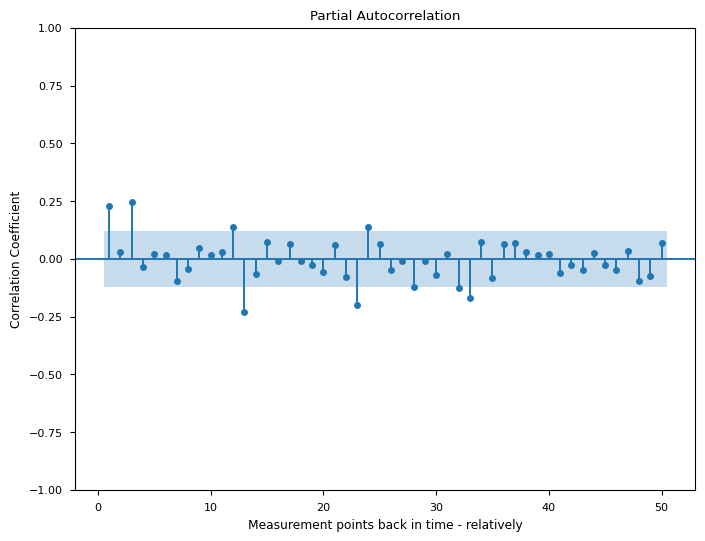

---


In [ ]:
# Import the necessary functions from the statsmodels.graphics.tsaplots module
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Close any existing plots
plt.close()

# Plot the autocorrelation function (ACF) of the '1st_diff' column of Germany_T2
# Drop any NaN values in the series
# Set the maximum number of lags to consider as 50
# Set zero=False to exclude the correlation at lag 0
plot_acf(Germany_T2['1st_diff'].dropna().values, lags=50, zero=False)

# Set the x-axis label for the ACF plot
plt.xlabel("Measurement points back in time - relatively")

# Display the ACF plot
plt.show()

# Plot the partial autocorrelation function (PACF) of the '1st_diff' column of Germany_T2
# Drop any NaN values in the series
# Set the maximum number of lags to consider as 50
# Set zero=False to exclude the correlation at lag 0
plot_pacf(Germany_T2['1st_diff'].dropna().values, lags=50, zero=False)

# Set the x-axis label for the PACF plot
plt.xlabel("Measurement points back in time - relatively")

# Set the y-axis label for the PACF plot
plt.ylabel('Correlation Coefficient')

# Display the PACF plot
plt.show()

# Print a separator line
print("---")


# Spain

## Load T2 data

In [11]:
def load_T2_data(country_name):
  T2_balances = pd.read_excel(data_folder+'/TGB_month_avg.xls',header=1)
  country = [x for x in T2_balances['REF_AREA.265 [desc.]'].unique() if country_name in x][0]
  col_to_use = ['Obs. date','Obs. value']
  country_T2 = T2_balances[T2_balances['REF_AREA.265 [desc.]']== country]
  country_T2 = country_T2[col_to_use].reset_index(drop=True)
  country_T2.rename(columns={'Obs. value':'T2_balance','Obs. date':'date'},inplace=True)
  country_T2 = country_T2.sort_values('date',ascending=True).reset_index(drop=True)
  return country_T2

In [12]:
# Load Spain T2 data
Spain_T2 = load_T2_data('Spain')

In [13]:
# Calculate the monthly change
Spain_T2['1st_diff'] = Spain_T2['T2_balance'].diff(1)

## Statistical tests on T2_balance change

### Plot distribution

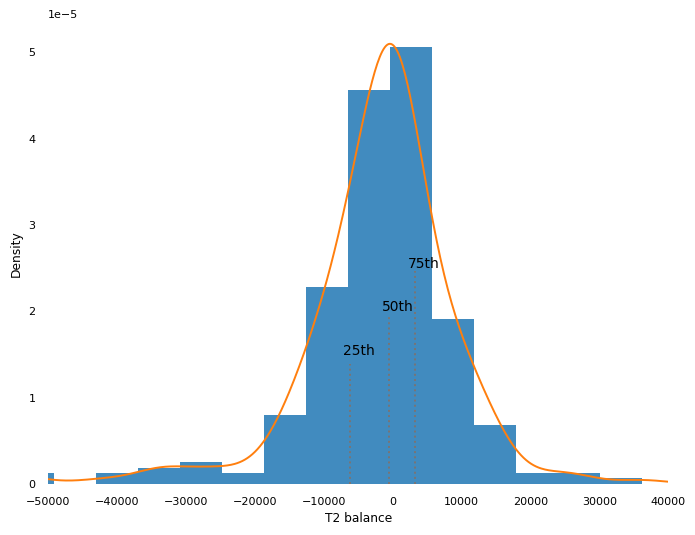

In [14]:

fig, ax = plt.subplots(figsize = (8,6))

# Plot
    # Plot histogram
Spain_T2['1st_diff'].plot(kind = "hist",alpha = 0.85, density = True, bins = 15) # change density to true, because KDE uses density
    # Plot KDE
Spain_T2['1st_diff'].plot(kind = "kde")

    # Quantile lines
quant_25, quant_50, quant_75 = Spain_T2['1st_diff'].quantile(0.25), Spain_T2['1st_diff'].quantile(0.5), Spain_T2['1st_diff'].quantile(0.75)
quants = [ [quant_25, 0.8, 0.26], [quant_50, 1, 0.36],  [quant_75, 0.8, 0.46]]
for i in quants:
    ax.axvline(i[0], color = '#797474', ymax = i[2], linestyle = ":")


# X
ax.set_xlabel("T2 balance")
    # Limit x range to 0-4
x_start, x_end = -50000, 40000
ax.set_xlim(x_start, x_end)


# Annotations
#ax.text(quant_5-.1, 0.5e-5, "5th",) #size = 2, alpha = 0.8)
ax.text(quant_25-1000, 1.5e-5, "25th",)# size = 2, alpha = 0.85)
ax.text(quant_50-1000, 2e-5, "50th",) #size = 2, alpha = 1)
ax.text(quant_75-1000, 2.5e-5, "75th",)# size = 2, alpha = 0.85)
#ax.text(quant_95-.25, 0, "95th Percentile",)# size = 2, alpha =.8)

# Overall
ax.grid(False)
#ax.set_title("Distribution of Monthly Change of Germany T2", size = 10, pad = 10)

    # Remove ticks and spines
ax.tick_params(left = False, bottom = False)
for ax, spine in ax.spines.items():
    spine.set_visible(False)

plt.show()

### ADF test

In [15]:
# Import the adfuller function from the statsmodels.tsa.stattools module
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test on the '1st_diff' column of Germany_T2 after dropping any NaN values
result = adfuller(Spain_T2['1st_diff'].dropna().values)

# Print the ADF statistic from the test result
print('ADF Statistic: %f' % result[0])

# Print the p-value from the test result
print('p-value: %f' % result[1])

# Print the critical values from the test result
print('Critical Values:')
# Iterate over the dictionary of critical values and print each key-value pair
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.733286
p-value: 0.000001
Critical Values:
	1%: -3.455
	5%: -2.873
	10%: -2.573


### Series decomposition

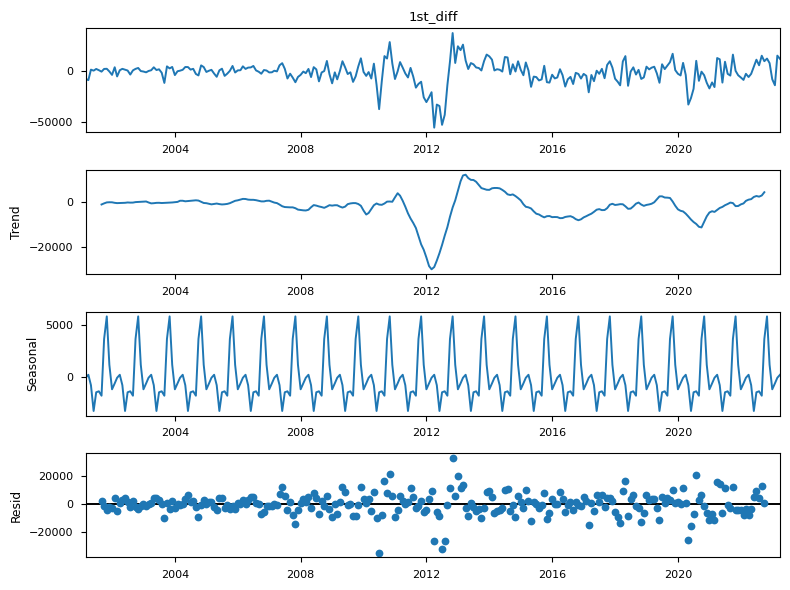

In [17]:
# Import the seasonal_decompose function from the statsmodels.tsa.seasonal module
from statsmodels.tsa.seasonal import seasonal_decompose

# Close any existing plots
plt.close()

# Perform seasonal decomposition on the '1st_diff' column of Germany_T2
# Set the index of Germany_T2 as 'date' and resample it to a monthly frequency (M)
# Drop any NaN values in the resampled series
# Use an additive model for decomposition
analysis1 = seasonal_decompose(Spain_T2.set_index('date').asfreq('M')['1st_diff'].dropna(), model="additive")

# Plot the decomposition results
analysis1.plot()

# Display the plot
plt.show()

In [18]:
analysis1.seasonal.value_counts()

-98.876      23
188.599      23
-814.248     22
-3296.178    22
-1497.491    22
-1401.418    22
-1826.501    22
3638.682     22
5809.871     22
1150.297     22
-1209.948    22
-642.788     22
Name: seasonal, dtype: int64

### Autocorrelation and partial autocorrelation

In [ ]:
# Import the acf function from the statsmodels.tsa.stattools module
from statsmodels.tsa.stattools import acf

# Calculate the autocorrelation function (ACF) of the '1st_diff' column of Spain_T2
# Drop any NaN values in the series
# Set the maximum number of lags to consider as 50
acf_b = acf(Spain_T2['1st_diff'].dropna().values, nlags=50)

# Find the indices where the absolute value of the ACF is greater than 0.15
lag_indices = np.where(abs(acf_b) > 0.15)

(array([ 0,  1,  2,  3,  4, 14, 16, 17, 30, 31]),)

In [ ]:
# Import the pacf function from the statsmodels.tsa.stattools module
from statsmodels.tsa.stattools import pacf

# Calculate the partial autocorrelation function (PACF) of the '1st_diff' column of Spain_T2
# Drop any NaN values in the series
# Set the maximum number of lags to consider as 50
pacf_b = pacf(Spain_T2['1st_diff'].dropna().values, nlags=50)

# Find the indices where the absolute value of the PACF is greater than 0.15
lag_indices = np.where(abs(pacf_b) > 0.15)


(array([0, 1, 7]),)

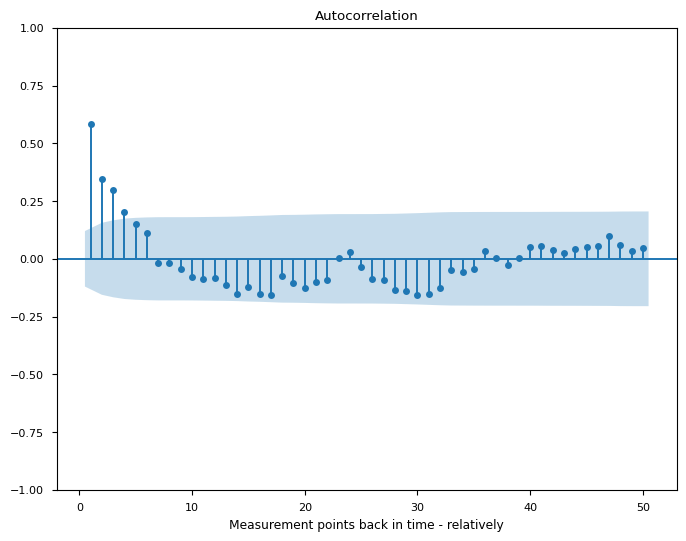

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


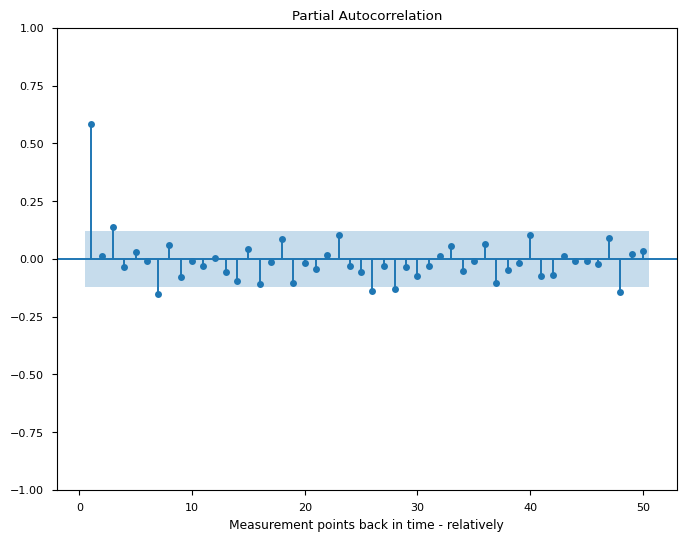

---


In [ ]:
# Import the necessary functions from the statsmodels.graphics.tsaplots module
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Close any existing plots
plt.close()

# Plot the autocorrelation function (ACF) of the '1st_diff' column of Spain_T2
# Drop any NaN values in the series
# Set the maximum number of lags to consider as 50
# Set zero=False to exclude the correlation at lag 0
plot_acf(Spain_T2['1st_diff'].dropna().values, lags=50, zero=False)

# Set the x-axis label for the ACF plot
plt.xlabel("Measurement points back in time - relatively")

# Display the ACF plot
plt.show()

# Plot the partial autocorrelation function (PACF) of the '1st_diff' column of Spain_T2
# Drop any NaN values in the series
# Set the maximum number of lags to consider as 50
# Set zero=False to exclude the correlation at lag 0
plot_pacf(Spain_T2['1st_diff'].dropna().values, lags=50, zero=False)

# Set the x-axis label for the PACF plot
plt.xlabel("Measurement points back in time - relatively")

# Display the PACF plot
plt.show()

# Print a separator line
print("---")


# Italy

## Load T2 data

In [ ]:
def load_T2_data(country_name):
  T2_balances = pd.read_excel(data_folder+'/TGB_month_avg.xls',header=1)
  country = [x for x in T2_balances['REF_AREA.265 [desc.]'].unique() if country_name in x][0]
  col_to_use = ['Obs. date','Obs. value']
  country_T2 = T2_balances[T2_balances['REF_AREA.265 [desc.]']== country]
  country_T2 = country_T2[col_to_use].reset_index(drop=True)
  country_T2.rename(columns={'Obs. value':'T2_balance','Obs. date':'date'},inplace=True)
  country_T2 = country_T2.sort_values('date',ascending=True).reset_index(drop=True)
  return country_T2

In [ ]:
# Load Italy data
Italy_T2 = load_T2_data('Italy')

In [ ]:
# Calculate monthly changes
Italy_T2['1st_diff'] = Italy_T2['T2_balance'].diff(1)

## Statistical tests on T2_balance change

### Plot distribution

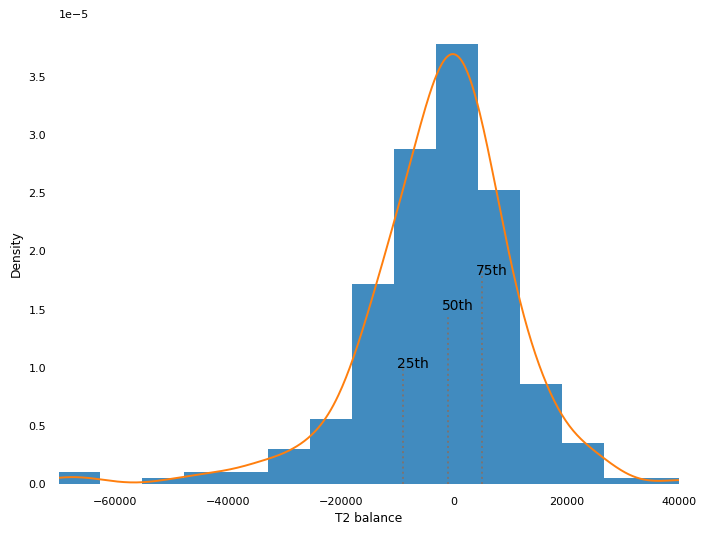

In [ ]:

fig, ax = plt.subplots(figsize = (8,6))

# Plot
    # Plot histogram
Italy_T2['1st_diff'].plot(kind = "hist",alpha = 0.85, density = True, bins = 15) # change density to true, because KDE uses density
    # Plot KDE
Italy_T2['1st_diff'].plot(kind = "kde")

    # Quantile lines
quant_25, quant_50, quant_75 = Italy_T2['1st_diff'].quantile(0.25), Italy_T2['1st_diff'].quantile(0.5), Italy_T2['1st_diff'].quantile(0.75)
quants = [ [quant_25, 0.8, 0.26], [quant_50, 1, 0.36],  [quant_75, 0.8, 0.46]]
for i in quants:
    ax.axvline(i[0], color = '#797474', ymax = i[2], linestyle = ":")


# X
ax.set_xlabel("T2 balance")
    # Limit x range to 0-4
x_start, x_end = -70000, 40000
ax.set_xlim(x_start, x_end)

# # Y
# ax.set_ylim(0, 1)
# ax.set_yticklabels([])
# ax.set_ylabel("")

# Annotations
#ax.text(quant_5-.1, 0.5e-5, "5th",) #size = 2, alpha = 0.8)
ax.text(quant_25-1000, 1e-5, "25th",)# size = 2, alpha = 0.85)
ax.text(quant_50-1000, 1.5e-5, "50th",) #size = 2, alpha = 1)
ax.text(quant_75-1000, 1.8e-5, "75th",)# size = 2, alpha = 0.85)
#ax.text(quant_95-.25, 0, "95th Percentile",)# size = 2, alpha =.8)

# Overall
ax.grid(False)
#ax.set_title("Distribution of Monthly Change of Germany T2", size = 10, pad = 10)

    # Remove ticks and spines
ax.tick_params(left = False, bottom = False)
for ax, spine in ax.spines.items():
    spine.set_visible(False)

plt.show()

### ADF test

In [ ]:
# Import the adfuller function from the statsmodels.tsa.stattools module
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test on the '1st_diff' column of Germany_T2 after dropping any NaN values
result = adfuller(Italy_T2['1st_diff'].dropna().values)

# Print the ADF statistic from the test result
print('ADF Statistic: %f' % result[0])

# Print the p-value from the test result
print('p-value: %f' % result[1])

# Print the critical values from the test result
print('Critical Values:')
# Iterate over the dictionary of critical values and print each key-value pair
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.905860
p-value: 0.000034
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573


### Seasonal decomposition

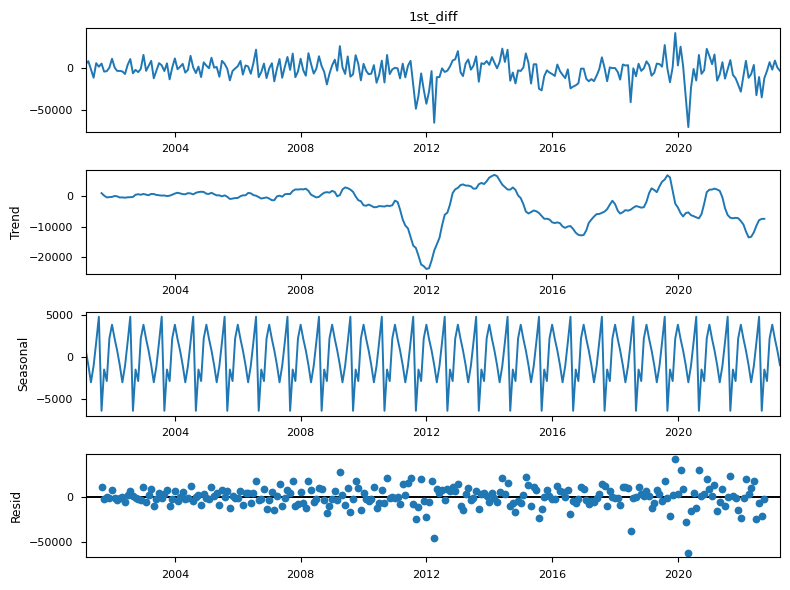

In [ ]:
# Import the seasonal_decompose function from the statsmodels.tsa.seasonal module
from statsmodels.tsa.seasonal import seasonal_decompose

# Close any existing plots
plt.close()

# Perform seasonal decomposition on the '1st_diff' column of Germany_T2
# Set the index of Germany_T2 as 'date' and resample it to a monthly frequency (M)
# Drop any NaN values in the resampled series
# Use an additive model for decomposition
sd = seasonal_decompose(Italy_T2.set_index('date').asfreq('M')['1st_diff'].dropna(), model="additive")

# Plot the decomposition results
sd.plot()

# Display the plot
plt.show()

In [ ]:
sd.seasonal.value_counts()

823.945      23
-952.230     23
-3004.366    22
-1031.443    22
1785.306     22
4837.686     22
-6412.041    22
-1475.446    22
-2854.696    22
2232.397     22
3883.360     22
2167.529     22
Name: seasonal, dtype: int64

### Autocorrelation and partial autocorrelation

In [ ]:
# Import the acf function from the statsmodels.tsa.stattools module
from statsmodels.tsa.stattools import acf

# Calculate the autocorrelation function (ACF) of the '1st_diff' column of Spain_T2
# Drop any NaN values in the series
# Set the maximum number of lags to consider as 50
acf_b = acf(Italy_T2['1st_diff'].dropna().values, nlags=50)

# Find the indices where the absolute value of the ACF is greater than 0.15
lag_indices = np.where(abs(acf_b) > 0.15)

(array([ 0,  1,  3,  6, 32, 33]),)

In [ ]:
# Import the pacf function from the statsmodels.tsa.stattools module
from statsmodels.tsa.stattools import pacf

# Calculate the partial autocorrelation function (PACF) of the '1st_diff' column of Spain_T2
# Drop any NaN values in the series
# Set the maximum number of lags to consider as 50
pacf_b = pacf(Italy_T2['1st_diff'].dropna().values, nlags=50)

# Find the indices where the absolute value of the PACF is greater than 0.15
lag_indices = np.where(abs(pacf_b) > 0.15)

(array([ 0,  1,  3,  6, 33]),)

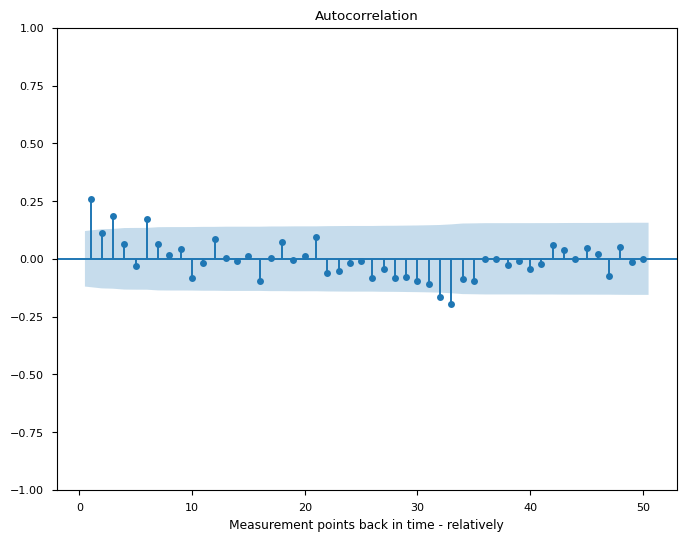

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


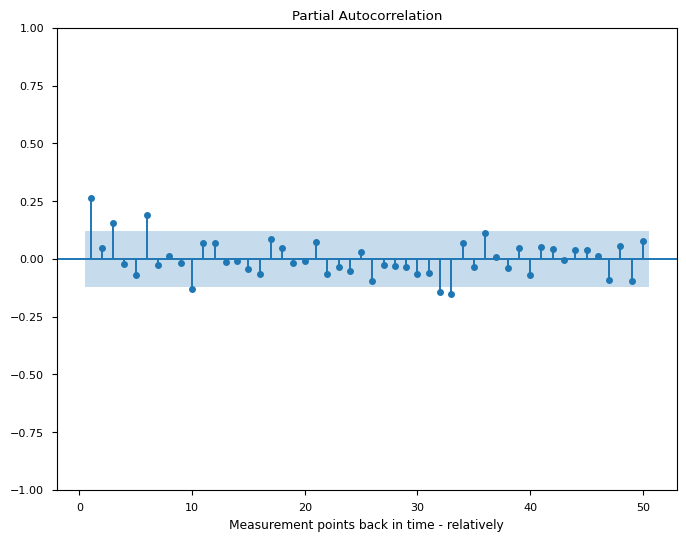

---


In [ ]:
# Import the necessary functions from the statsmodels.graphics.tsaplots module
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Close any existing plots
plt.close()

# Plot the autocorrelation function (ACF) of the '1st_diff' column of Spain_T2
# Drop any NaN values in the series
# Set the maximum number of lags to consider as 50
# Set zero=False to exclude the correlation at lag 0
plot_acf(Italy_T2['1st_diff'].dropna().values, lags=50, zero=False)

# Set the x-axis label for the ACF plot
plt.xlabel("Measurement points back in time - relatively")

# Display the ACF plot
plt.show()

# Plot the partial autocorrelation function (PACF) of the '1st_diff' column of Spain_T2
# Drop any NaN values in the series
# Set the maximum number of lags to consider as 50
# Set zero=False to exclude the correlation at lag 0
plot_pacf(Italy_T2['1st_diff'].dropna().values, lags=50, zero=False)

# Set the x-axis label for the PACF plot
plt.xlabel("Measurement points back in time - relatively")

# Display the PACF plot
plt.show()

# Print a separator line
print("---")
